In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix as cm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
%matplotlib inline

# Autoencoder

In [3]:
# Read MNIST data here...
mnist_dir='C:\\Users\\talha\\Documents\\datasets\\mnist'
datasets = tf.contrib.learn.datasets.mnist.load_mnist(mnist_dir) # Downloads into mnist_dir
type(datasets)

Extracting C:\Users\talha\Documents\datasets\mnist\train-images-idx3-ubyte.gz
Extracting C:\Users\talha\Documents\datasets\mnist\train-labels-idx1-ubyte.gz
Extracting C:\Users\talha\Documents\datasets\mnist\t10k-images-idx3-ubyte.gz
Extracting C:\Users\talha\Documents\datasets\mnist\t10k-labels-idx1-ubyte.gz


tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [4]:
#help(datasets)
train=datasets.__getitem__(0)
validation=datasets.__getitem__(1)
test=datasets.__getitem__(2)
# train --> images, labels, num_examples
(train_images, train_labels, train_numEx) = (train.images, train.labels, train.num_examples)
(validation_images, validation_labels, validation_numEx) = (validation.images, validation.labels, validation.num_examples)
(test_images, test_labels, test_numEx) = (test.images, test.labels, test.num_examples)

print(train_images.shape, validation_images.shape, test_images.shape)

(55000, 784) (5000, 784) (10000, 784)


In [5]:
train_data = np.empty((0, 784), dtype=np.float32)
train_data_labels = np.empty((0), dtype=np.uint8)

train_dict={}
label_dict={}

for i in np.arange(0, 10):
    train_dict[i] = train_images[np.where(train_labels == i)[0][:100]]
    label_dict[i] = train_labels[np.where(train_labels == i)[0][:100]]

for i in np.arange(0, 10):
    train_data = np.concatenate([train_data, train_dict[i]])
    train_data_labels = np.concatenate([train_data_labels, label_dict[i]])

In [9]:
def plot_image(input_):
    plt.imshow(np.reshape(input_, (28, 28)), cmap="gray")
    return plt

class Color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [88]:
def get_weights_and_biases(N, inputs):
    weights = {
        'encoder': tf.Variable(tf.random_normal([inputs, N])),
        'decoder': tf.Variable(tf.random_normal([N, inputs])),
    }
    biases = {
        'encoder': tf.Variable(tf.random_normal([N])),
        'decoder': tf.Variable(tf.random_normal([inputs])),
    }
    return (weights, biases)

    
def encoder(x, weights, biases, activation):
    if activation == 'relu':
        enc = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder']),
                                biases['encoder']))
    if activation == 'sigmoid':
        enc = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder']),
                                biases['encoder']))
    return enc


def decoder(x, weights, biases, activation):
    if activation == 'relu':
        dec = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder']),
                                   biases['decoder']))
    if activation == 'sigmoid':
        dec = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder']),
                                   biases['decoder']))
    return dec
    
    
def train(N, inputs, activation='sigmoid'):
    """
    """
    (weights, biases) = get_weights_and_biases(N, inputs)
    
    with tf.device('/cpu:0'):
        X = tf.placeholder(tf.float32, [None, num_input], name='Input')

        encoder_ = encoder(X, weights, biases, activation)
        decoder_ = decoder(encoder_, weights, biases, activation)

        y_pred = decoder_
        y_true = X

        # Define loss and optimizer, minimize the squared error
        loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()
    
    
    sess.run(init)
    
    # Training cycle
    for epoch in range(train_iters):
        avg_cost = 0.
        total_batch = int(train_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            offset = (i * batch_size) % (train_examples)
            batch_x = train_data[offset:offset+batch_size]

            # Run training step and cost op 
            t, c = sess.run(
                            [optimizer, loss], 
                            feed_dict={X: batch_x}
                            )

            # Compute average cost
            avg_cost += c 

        avg_cost /= total_batch
        reconstruction_loss.append(avg_cost)
        
        if epoch == 0 or (epoch+1) % 5 == 0:
            print("Epoch: {:3d}, cost = {:.5f}".format(epoch+1, round(avg_cost,4)))
    
    
    # Plot reconstruction loss here...
    fig = plt.figure(1, figsize=(8,5))
    plt.xlabel("Epochs")
    plt.ylabel("AE reconstruction loss")
    plt.plot(reconstruction_loss)
    plt.show()
    
    
    # Get latent representation for all training data
    # 1000 images in training data, so we have latent 
    # representation for all of them now i.e there are
    # 1000 points in the latent space.
    latent_rep = np.empty((0, N), dtype=np.float32)
    for ind, data in enumerate(train_data):
        l = sess.run(
                    [encoder_], 
                    feed_dict={X: data.reshape(1,784)}
                    )
        latent_rep = np.concatenate([latent_rep, l[0]])


    # Fit KNN on latent representations.
    model = KNeighborsClassifier(n_neighbors=50, algorithm='brute', metric='cosine')
    model.fit(latent_rep, train_data_labels)


    # Select an image and Get 50 NN for the selected image in latent space
    img_indices = np.arange(0,1000,100)
    selected_images = train_data[img_indices]
    selected_images_labels = train_data_labels[img_indices]
    l = sess.run(
                [encoder_], 
                feed_dict={X: selected_images.reshape(10,784)}
                )

    latent=l[0]
    # print (latent.shape)

    for i in range(0,10):
        print ("Selected Image for: ", selected_images_labels[i])
        (dist,indices) = model.kneighbors([latent[i]])
        print ("Nearest neighbors in latent space: ")
        nn = train_data_labels[indices]
        print (nn)

        true = np.full(50, selected_images_labels[i])
        pred = nn
        p,r,f,_ = precision_recall_fscore_support(true.reshape(50), pred.reshape(50), average='micro')
        print (Color.RED + Color.BOLD + "Precision" + Color.END + "= " + str(round(p,4)) + "\n" 
               + Color.RED + Color.BOLD + "Recall" + Color.END + "= " + str(round(r,4)))
        print ()
        
        
    
    print (Color.BLUE + "Original Images from Training Data..." + Color.END)
    images = train_data[np.arange(0,1000,100)]
    g = sess.run([decoder_], feed_dict={X: images.reshape(10,784)})
    reconstructed = g[0]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.reshape(images[i], (28, 28)), cmap="gray")

    plt.show()

    
    print ("\n\n" + Color.BLUE + "Reconstructed Images..."+ Color.END +"\n\n")
    # Reconstructed Images
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.reshape(reconstructed[i], (28, 28)), cmap="gray")

    plt.show()
            
    return (encoder_, decoder_)

## For N=2, sigmoid activation

Epoch:   1, cost = 0.25100
Epoch:   5, cost = 0.08920
Epoch:  10, cost = 0.06860
Epoch:  15, cost = 0.06570
Epoch:  20, cost = 0.06520
Epoch:  25, cost = 0.06490
Epoch:  30, cost = 0.06470
Epoch:  35, cost = 0.06470
Epoch:  40, cost = 0.06440


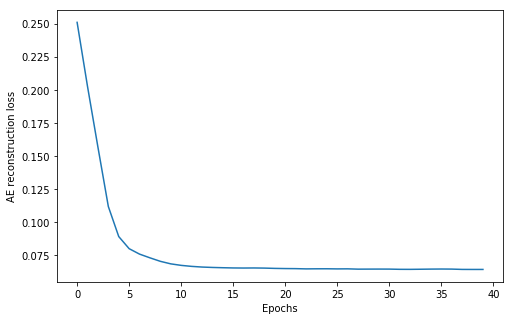

Selected Image for:  0
Nearest neighbors in latent space: 
[[4 3 4 5 5 6 6 6 6 5 5 5 5 5 5 5 3 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4]]
Precision= 0.0
Recall= 0.0

Selected Image for:  1
Nearest neighbors in latent space: 
[[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1]]
Precision= 0.8
Recall= 0.8

Selected Image for:  2
Nearest neighbors in latent space: 
[[4 3 4 5 5 6 6 6 6 5 5 5 5 5 5 5 3 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4]]
Precision= 0.0
Recall= 0.0

Selected Image for:  3
Nearest neighbors in latent space: 
[[6 3 6 5 9 4 8 5 4 6 5 8 6 5 8 3 2 8 7 7 4 9 8 3 6 4 6 4 6 8 5 4 5 8 6 8 8
  4 6 8 5 3 7 4 3 9 3 6 8 9]]
Precision= 0.12
Recall= 0.12

Selected Image for:  4
Nearest neighbors in latent space: 
[[4 7 2 6 3 5 8 4 5 8 6 6 0 8 9 5 8 6 8 9 9 5 4 6 8 3 5 8 3 9 5 6 6 2 2 4 4
  9 5 7 3 7 3 5 8 5 4 9 6 8]]
Precision= 0.12
Recall= 0.12

Selected Image for:  5
Nearest 

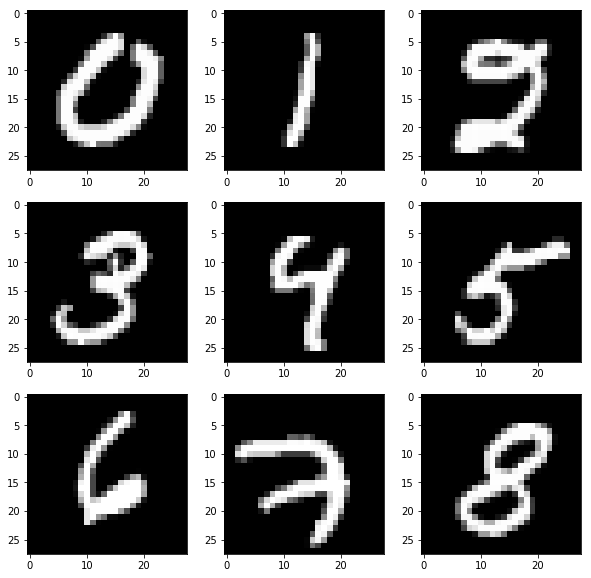



Reconstructed Images...




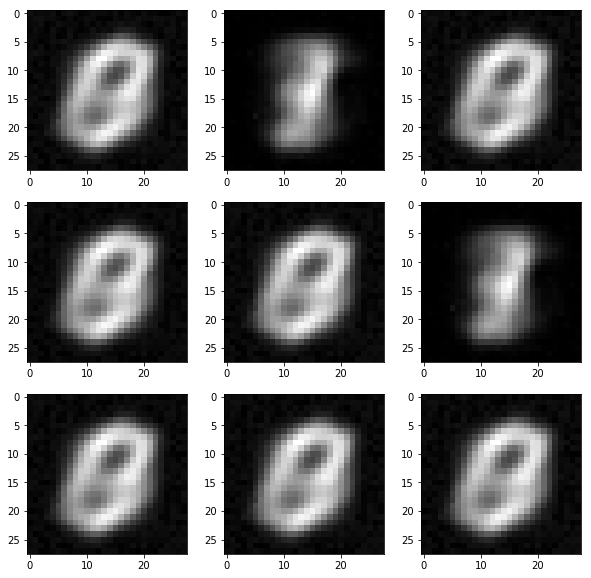

In [90]:
# Hyperparameters
learning_rate = 0.01
train_iters = 40
batch_size = 32
train_examples = 1000


N = 2
num_input = 784
reconstruction_loss = []
sess = tf.Session()
(encoder_out, decoder_out) = train(N, num_input, activation='sigmoid')
sess.close()

## For N= 5, sigmoid activation

Epoch:   1, cost = 0.25970
Epoch:   5, cost = 0.07620
Epoch:  10, cost = 0.06920
Epoch:  15, cost = 0.06470
Epoch:  20, cost = 0.06190
Epoch:  25, cost = 0.06080
Epoch:  30, cost = 0.05800
Epoch:  35, cost = 0.05670
Epoch:  40, cost = 0.05610


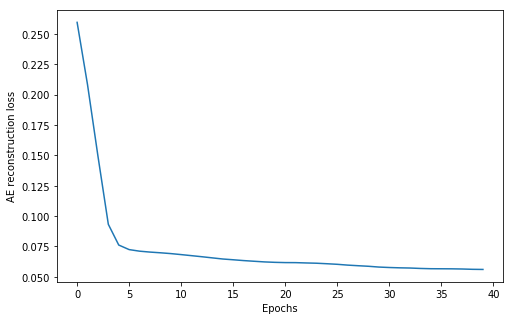

Selected Image for:  0
Nearest neighbors in latent space: 
[[2 8 0 6 6 6 8 6 6 6 3 3 3 3 6 6 0 6 0 2 5 6 2 0 0 0 2 0 0 0 0 0 2 0 0 0 6
  0 0 0 0 0 0 0 0 0 2 0 0 2]]
Precision= 0.5
Recall= 0.5

Selected Image for:  1
Nearest neighbors in latent space: 
[[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1]]
Precision= 0.98
Recall= 0.98

Selected Image for:  2
Nearest neighbors in latent space: 
[[0 0 5 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 6 2 0 6 6 6 6 6 6 5 2 2 6 6 0 0 2 0 0
  0 0 0 8 0 0 0 0 0 6 8 0 2]]
Precision= 0.14
Recall= 0.14

Selected Image for:  3
Nearest neighbors in latent space: 
[[2 8 2 0 8 2 3 8 8 2 8 0 8 3 8 8 3 2 2 3 8 8 2 8 8 8 2 8 8 2 8 8 8 8 8 8 3
  8 8 8 8 8 8 8 8 8 8 2 8 8]]
Precision= 0.1
Recall= 0.1

Selected Image for:  4
Nearest neighbors in latent space: 
[[4 4 4 7 9 4 4 4 9 9 4 9 9 9 9 6 9 4 9 5 9 4 4 9 9 7 4 7 4 4 4 4 7 9 4 9 7
  7 4 9 9 4 7 4 4 9 7 4 4 4]]
Precision= 0.46
Recall= 0.46

Selected Image for:  5
Neares

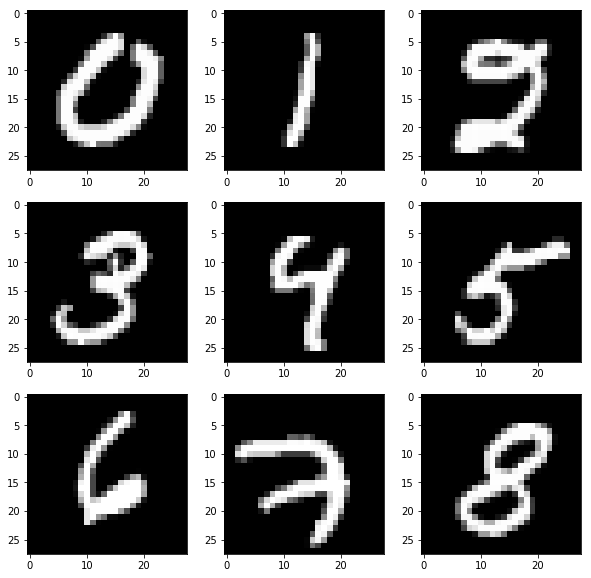



Reconstructed Images...




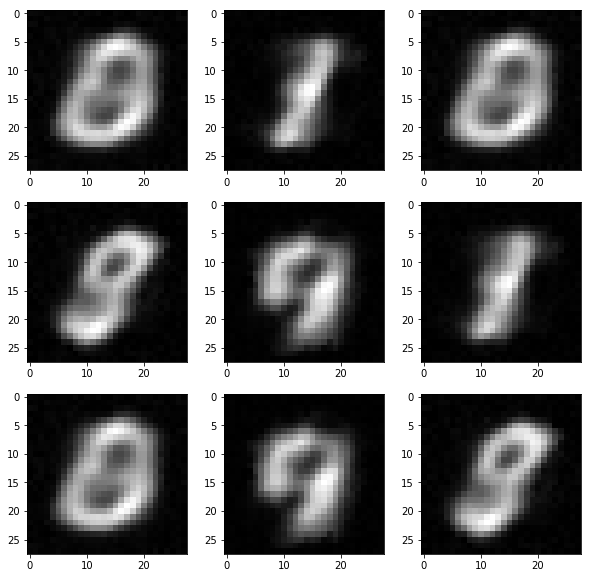

In [91]:
# Hyperparameters
learning_rate = 0.01
train_iters = 40
batch_size = 32
train_examples = 1000

N = 5
num_input = 784
reconstruction_loss = []
sess = tf.Session()
(encoder_out, decoder_out) = train(N, num_input, activation='sigmoid')

## For N=10, sigmoid activation

Epoch:   1, cost = 0.26190
Epoch:   5, cost = 0.07160
Epoch:  10, cost = 0.06940
Epoch:  15, cost = 0.06500
Epoch:  20, cost = 0.05930
Epoch:  25, cost = 0.05660
Epoch:  30, cost = 0.05280
Epoch:  35, cost = 0.05060
Epoch:  40, cost = 0.04950


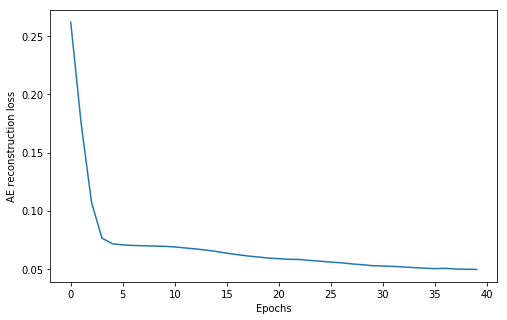

Selected Image for:  0
Nearest neighbors in latent space: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 0 0
  0 3 0 3 0 0 0 3 0 0 0 2 8]]
Precision= 0.84
Recall= 0.84

Selected Image for:  1
Nearest neighbors in latent space: 
[[1 5 5 5 4 5 9 4 1 5 5 5 5 9 1 1 5 4 1 1 6 5 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 4 5]]
Precision= 0.62
Recall= 0.62

Selected Image for:  2
Nearest neighbors in latent space: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 0
  0 3 0 3 0 0 0 3 0 0 0 2 8]]
Precision= 0.06
Recall= 0.06

Selected Image for:  3
Nearest neighbors in latent space: 
[[3 3 8 8 8 8 3 3 8 8 3 8 8 8 8 8 3 3 8 3 8 2 8 8 8 8 5 3 3 5 8 3 3 5 3 3 5
  3 5 3 3 3 8 3 3 3 5 3 3 3]]
Precision= 0.48
Recall= 0.48

Selected Image for:  4
Nearest neighbors in latent space: 
[[4 9 4 9 4 7 7 7 7 9 9 8 4 4 9 7 9 9 4 5 9 4 4 5 7 4 4 9 7 7 7 9 9 9 4 9 9
  9 7 7 4 5 7 7 9 7 9 3 9 4]]
Precision= 0.26
Recall= 0.26

Selected Image for:  5
Ne

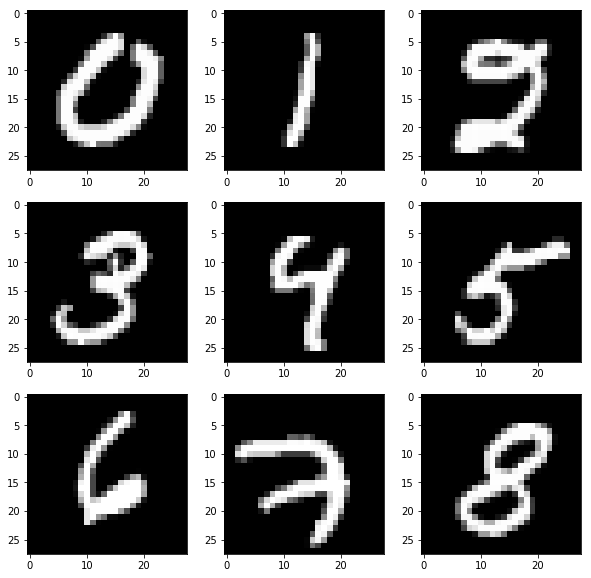



Reconstructed Images...




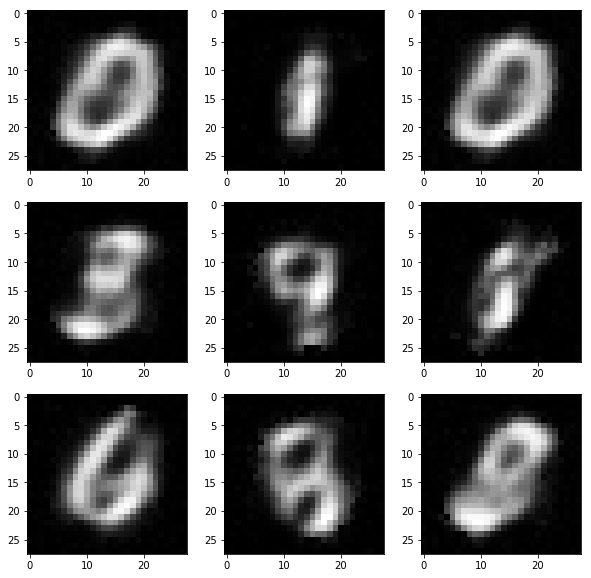

In [92]:
# Hyperparameters
learning_rate = 0.01
train_iters = 40
batch_size = 32
train_examples = 1000

N = 10
num_input = 784
reconstruction_loss = []
sess = tf.Session()
(encoder_out, decoder_out) = train(N, num_input, activation='sigmoid')
sess.close()

## For N=100, sigmoid activation

Epoch:   1, cost = 0.21550
Epoch:   5, cost = 0.08340
Epoch:  10, cost = 0.06270
Epoch:  15, cost = 0.05110
Epoch:  20, cost = 0.04570
Epoch:  25, cost = 0.04150
Epoch:  30, cost = 0.03860
Epoch:  35, cost = 0.03530
Epoch:  40, cost = 0.03440


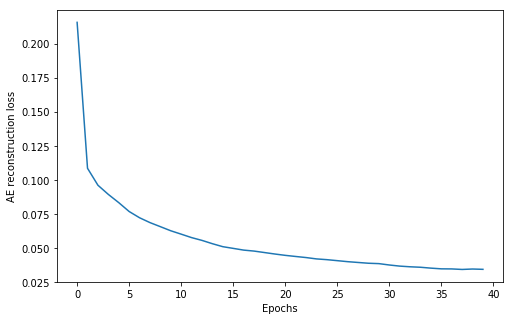

Selected Image for:  0
Nearest neighbors in latent space: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 3 0 0 0 0 0 0 0 0 0 0]]
Precision= 0.98
Recall= 0.98

Selected Image for:  1
Nearest neighbors in latent space: 
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1
  1 1 1 1 2 1 1 6 1 1 1 1 1]]
Precision= 0.94
Recall= 0.94

Selected Image for:  2
Nearest neighbors in latent space: 
[[2 2 3 2 0 0 2 0 3 3 0 0 3 0 0 0 0 3 0 3 0 0 1 0 3 0 0 7 0 3 0 3 3 0 3 0 0
  0 2 3 7 2 0 3 3 7 2 5 3 3]]
Precision= 0.14
Recall= 0.14

Selected Image for:  3
Nearest neighbors in latent space: 
[[3 3 3 3 3 3 3 3 3 3 3 5 8 3 3 8 8 8 3 3 3 3 8 3 8 5 3 5 3 3 8 8 8 8 9 8 8
  5 8 3 8 8 8 3 3 3 8 0 8 8]]
Precision= 0.5
Recall= 0.5

Selected Image for:  4
Nearest neighbors in latent space: 
[[4 4 4 4 4 4 9 4 9 9 7 9 4 4 9 9 4 4 4 9 9 4 9 3 9 4 7 9 4 9 9 4 4 9 4 7 7
  4 9 8 7 8 4 8 7 4 7 4 8 4]]
Precision= 0.46
Recall= 0.46

Selected Image for:  5
Near

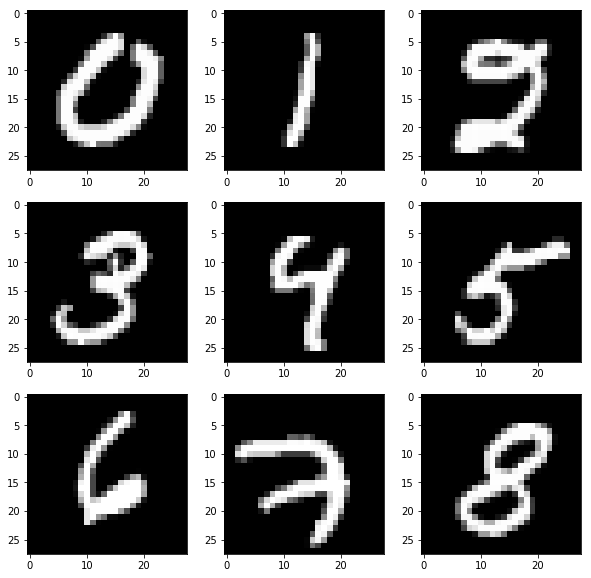



Reconstructed Images...




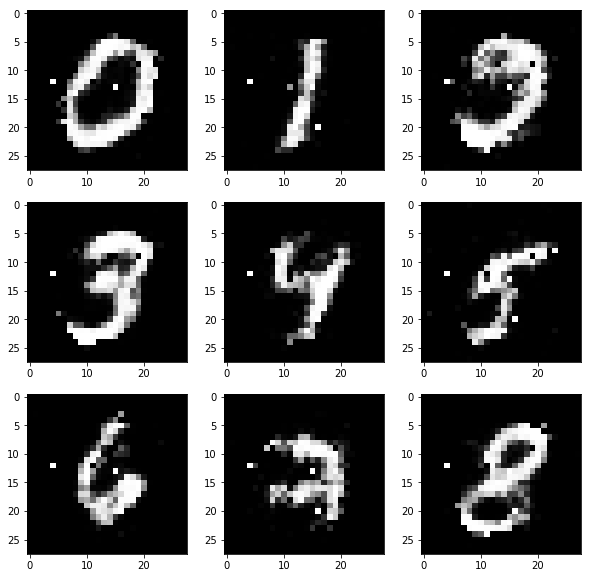

In [93]:
# Hyperparameters
learning_rate = 0.01
train_iters = 40
batch_size = 32
train_examples = 1000

N = 100
num_input = 784
reconstruction_loss = []
sess = tf.Session()
(encoder_out, decoder_out) = train(N, num_input, activation='sigmoid')
sess.close()

# PCA in latent space

In [34]:
def do_pca(N, data):
    pca = PCA(n_components=N)
    pca.fit(data)
    components = pca.components_
    O = pca.transform(train_data)
    return (pca, components, O)

In [73]:
def get_nn_for_images(model, X):
    # Select an image and Get 50 NN for the selected image in latent space
    img_indices = np.arange(0,1000,100)
    selected_images = X[img_indices]
    selected_images_labels = train_data_labels[img_indices]

    # Print the selected images, and their 50 nearest neighbors in latent space.
    for i in range(0,10):
        print (Color.RED + Color.BOLD + "Selected Image for: " + str(selected_images_labels[i]) + Color.END)
        (dist,indices) = model.kneighbors([selected_images[i]])
        print ("Nearest neighbors in latent space: ")
        nn = train_data_labels[indices]
        print (nn)

        true = np.full(50, selected_images_labels[i])
        pred = nn
        # Get precision and recall scores....
        p,r,f,_ = precision_recall_fscore_support(true.reshape(50), pred.reshape(50), average='micro')
        print (Color.RED + Color.BOLD + "Precision" + Color.END + "= " + str(round(p,4)) + ". " 
               + Color.RED  + Color.BOLD + "Recall" + Color.END + "= " + str(round(r,4)))
        print ()

## N=2

In [74]:
(pca, components, X) = do_pca(2, train_data)

# Fit KNN on latent representations.
model = KNeighborsClassifier(n_neighbors=50, algorithm='brute', metric='cosine')
model.fit(X, train_data_labels)

get_nn_for_images(model, X)

Selected Image for: 0
Nearest neighbors in latent space: 
[[0 0 2 5 0 0 0 0 6 0 0 2 2 3 0 0 0 8 6 0 3 3 2 0 2 2 6 0 8 8 0 0 0 2 6 3 0
  2 6 0 2 0 6 6 6 0 2 0 0 8]]
Precision= 0.46. Recall= 0.46

Selected Image for: 1
Nearest neighbors in latent space: 
[[1 4 1 9 3 1 1 1 9 9 7 1 6 9 1 1 1 1 1 1 1 2 1 1 1 4 1 2 1 1 1 1 4 1 4 6 1
  8 1 1 1 1 3 2 6 1 1 1 1 6]]
Precision= 0.62. Recall= 0.62

Selected Image for: 2
Nearest neighbors in latent space: 
[[2 6 8 0 5 0 6 0 3 0 9 0 3 6 3 0 0 3 0 5 0 2 8 6 3 3 0 6 5 0 3 2 3 6 0 3 5
  9 8 0 3 2 0 0 3 8 3 0 8 0]]
Precision= 0.08. Recall= 0.08

Selected Image for: 3
Nearest neighbors in latent space: 
[[3 3 0 0 6 6 3 3 0 0 6 3 6 5 9 5 0 6 0 2 8 0 8 0 0 6 0 8 2 0 2 0 0 9 6 2 2
  3 3 0 0 5 0 2 8 0 0 3 0 6]]
Precision= 0.16. Recall= 0.16

Selected Image for: 4
Nearest neighbors in latent space: 
[[4 4 7 8 7 3 9 5 9 4 9 5 7 7 9 9 8 9 4 5 9 4 8 9 9 9 4 7 9 7 8 5 8 9 7 7 9
  7 9 9 4 4 5 7 7 4 7 5 6 5]]
Precision= 0.18. Recall= 0.18

Selected Image for: 5
Nea

## N=5

In [75]:
(pca, components, X) = do_pca(5, train_data)
model = KNeighborsClassifier(n_neighbors=50, algorithm='brute', metric='cosine')
model.fit(X, train_data_labels)

get_nn_for_images(model, X)

Selected Image for: 0
Nearest neighbors in latent space: 
[[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]]
Precision= 0.94. Recall= 0.94

Selected Image for: 1
Nearest neighbors in latent space: 
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 6 1 5 1 1 1 6 2 1 1 1 6 5 1 1
  1 1 1 1 1 1 4 1 1 3 1 9 1]]
Precision= 0.8. Recall= 0.8

Selected Image for: 2
Nearest neighbors in latent space: 
[[2 5 3 3 3 5 0 3 3 2 3 5 3 3 3 0 5 3 0 3 5 0 0 0 8 3 5 3 5 0 0 3 0 2 3 0 3
  3 0 0 3 0 0 3 0 8 0 0 0 5]]
Precision= 0.06. Recall= 0.06

Selected Image for: 3
Nearest neighbors in latent space: 
[[3 3 3 3 3 8 5 8 3 3 3 3 5 8 3 3 8 5 3 1 3 8 8 3 8 3 8 8 8 8 3 2 8 3 3 8 8
  8 8 5 3 3 8 8 3 8 3 5 3 8]]
Precision= 0.46. Recall= 0.46

Selected Image for: 4
Nearest neighbors in latent space: 
[[4 4 9 5 7 7 7 7 5 9 7 9 4 9 7 5 7 7 4 4 7 7 7 4 7 9 7 4 9 4 9 9 4 9 9 7 4
  9 7 7 7 7 9 8 5 7 7 7 7 7]]
Precision= 0.2. Recall= 0.2

Selected Image for: 5
Nearest

## N=10

In [76]:
(pca, components, X) = do_pca(10, train_data)
model = KNeighborsClassifier(n_neighbors=50, algorithm='brute', metric='cosine')
model.fit(X, train_data_labels)

get_nn_for_images(model, X)

Selected Image for: 0
Nearest neighbors in latent space: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]]
Precision= 1.0. Recall= 1.0

Selected Image for: 1
Nearest neighbors in latent space: 
[[1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 9 1 1 6 1 1 1 1 1 1 1 1 1 1 7 1 1 1
  1 1 1 1 1 1 1 9 1 3 5 7 1]]
Precision= 0.84. Recall= 0.84

Selected Image for: 2
Nearest neighbors in latent space: 
[[2 2 2 3 0 3 3 3 3 3 3 3 0 3 3 0 3 0 3 3 5 3 3 0 2 3 0 1 3 0 0 0 3 3 5 3 3
  3 3 3 0 0 0 3 0 0 0 3 5 0]]
Precision= 0.08. Recall= 0.08

Selected Image for: 3
Nearest neighbors in latent space: 
[[3 3 3 5 3 3 8 5 8 8 3 8 3 8 3 8 8 3 8 3 8 8 8 8 8 8 3 8 5 8 8 8 8 8 3 8 5
  3 3 5 3 8 8 3 8 8 8 8 8 3]]
Precision= 0.34. Recall= 0.34

Selected Image for: 4
Nearest neighbors in latent space: 
[[4 4 4 4 4 9 4 9 4 4 9 9 4 4 9 9 4 4 9 9 4 7 9 4 5 4 5 9 9 9 9 5 5 4 4 9 4
  4 4 9 7 9 9 7 9 9 4 9 5 9]]
Precision= 0.42. Recall= 0.42

Selected Image for: 5
Neare